In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/wzb/ros2ws/coffee_ws/src/coffee_detect/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

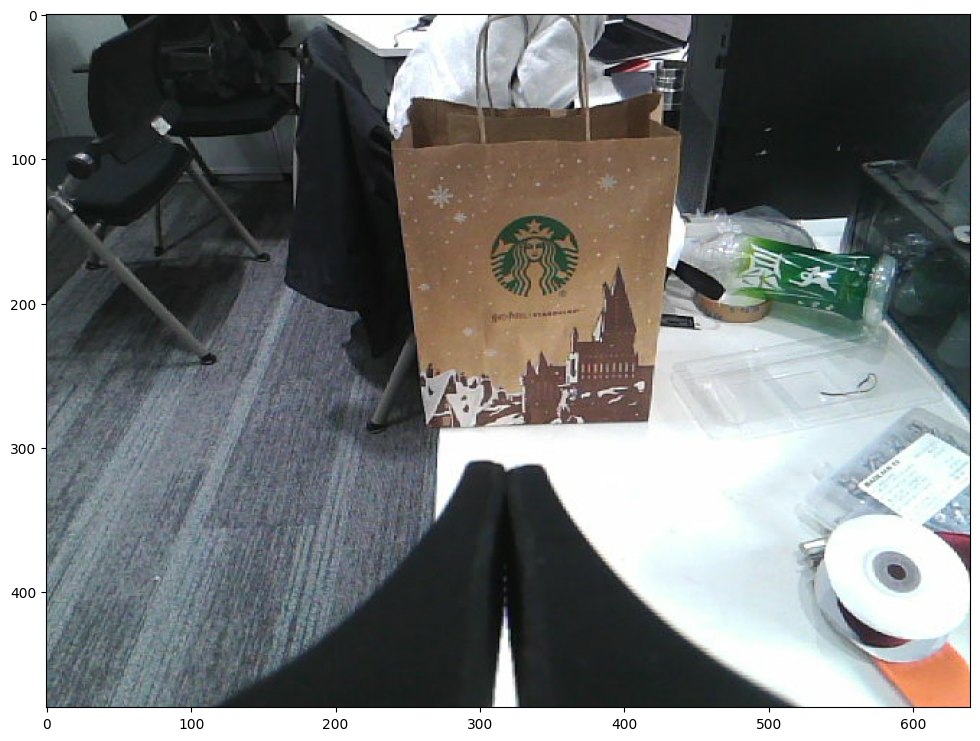

In [4]:
image = cv2.imread('/home/wzb/ros2ws/coffee_ws/src/coffee_detect/coffeetest/img/new_img.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)
plt.figure(figsize=(12,9))
plt.imshow(image)
plt.axis('on')
plt.show()

In [5]:
# 1. 转 HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# 2. 颜色分割（默认：深色提手）
lower = np.array([0, 30, 20])    
upper = np.array([40, 255, 200])   
mask = cv2.inRange(hsv, lower, upper)

# 3. 形态学去噪
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# 分析连通域
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

# 创建输出掩码
mask_clean = np.zeros_like(mask)

min_area = 1000
for i in range(1, num_labels):  # 0 是背景
    if stats[i, cv2.CC_STAT_AREA] > min_area:
        mask_clean[labels == i] = 255
cv2.imwrite("mask3.png", mask_clean)
# 找轮廓
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

best_bag = None
max_area = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 1000:  # 袋子通常 > 2000 像素²
        continue
    
    # 必须是竖直矩形（高 > 宽）
    x, y, w, h = cv2.boundingRect(cnt)
    if h < w:  # 横向的不是袋子
        continue
        
    if area > max_area:
        max_area = area
        best_bag = (x, y, x+w, y+h)

if best_bag is None:
    print("❌ 未检测到袋子")


In [6]:

input_box = np.array(best_bag)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

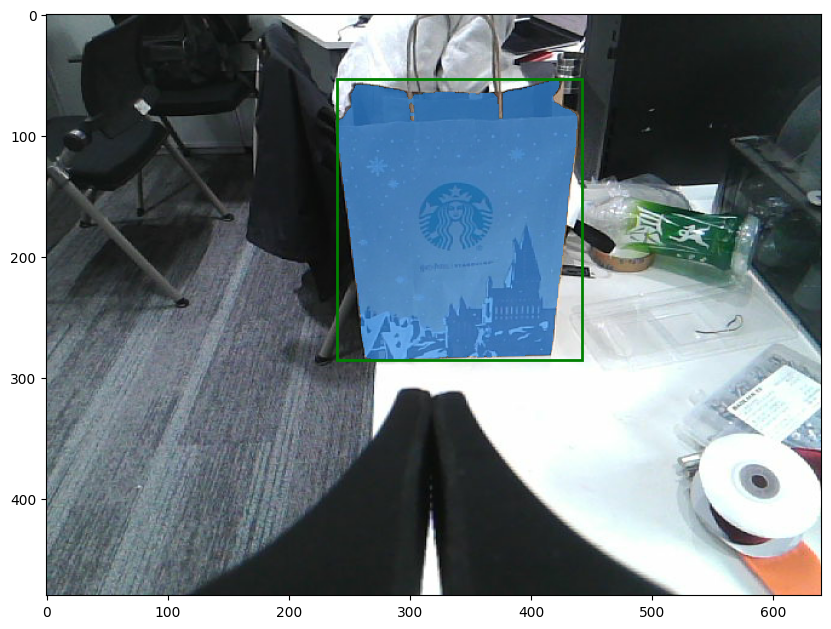

In [7]:

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[2], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [8]:
new_depth = cv2.imread('/home/wzb/ros2ws/coffee_ws/src/coffee_detect/coffeetest/img/new_depth_raw.tiff', cv2.IMREAD_UNCHANGED)
# 创建掩码（只保留袋子区域）
mask = masks[2].astype(np.uint8) * 255

# 提取深度值（只取有效深度）
depth_values = new_depth[mask == 255]
depth_values = depth_values[depth_values > 0]  # 去除无效深度（0）
if len(depth_values) == 0:
    print("❌ 无有效深度")
else:
    max_depth = np.max(depth_values)
    min_depth = np.min(depth_values)
    median_depth = np.median(depth_values)
    print(f"✅ 袋子深度统计（单位 mm）：最大={max_depth}, 最小={min_depth}, 中值={median_depth}")


✅ 袋子深度统计（单位 mm）：最大=1482, 最小=494, 中值=553.0


In [9]:
# 获取轮廓内所有像素坐标
points_2d = np.where(mask == 255)  # (y, x)
ys, xs = points_2d[0], points_2d[1]

# 获取对应深度
depths = new_depth[ys, xs].astype(np.float32)
valid = depths > 0
xs, ys, depths = xs[valid], ys[valid], depths[valid]

# 反投影到3D
fx, fy = 490.2380676269531, 490.2380676269531
cx, cy = 316.89483642578125, 209.28350830078125

zs = depths / 1000.0  # mm → m
xs_3d = (xs - cx) * zs / fx
ys_3d = (ys - cy) * zs / fy

# 点云：Nx3
points_3d = np.stack([xs_3d, ys_3d, zs], axis=-1)  # (N, 3)

In [10]:
import plotly.graph_objects as go
import numpy as np

# 假设 points_3d 是一个 NumPy 数组，形状为 (N, 3)
# 如果还不是 numpy 数组，先转换：
# points_3d = np.asarray(points_3d)
img_color = image[ys, xs].reshape(-1, 3)
# 创建 3D 散点图 从RGB图片取色
fig = go.Figure(data=go.Scatter3d(
    x=points_3d[:, 0],
    y=points_3d[:, 1],
    z=points_3d[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=img_color,  # 使用原图颜色
        opacity=0.8
    )
))

# 设置窗口标题（在 Plotly 中是 layout.title）
fig.update_layout(
    title="Bag Point Cloud",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'  # 保持真实比例
    ),
    width=800,
    height=600
)

# 显示（Jupyter 中自动嵌入；脚本中会打开浏览器）
fig.show()

In [11]:
import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R_scipy

# bag_pcd: 你的正面点云
bag_pcd = o3d.geometry.PointCloud()
bag_pcd.points = o3d.utility.Vector3dVector(points_3d)

# 用 RANSAC 拟合平面（正面）
plane_model, inliers = bag_pcd.segment_plane(
    distance_threshold=0.01,  # 10mm，适合硬纸箱
    ransac_n=5,
    num_iterations=10000
)

a, b, c, d = plane_model
normal = np.array([a, b, c])  # 平面法向量

# 提取内点（正面点）
front_pcd = bag_pcd.select_by_index(inliers)
front_points = np.asarray(front_pcd.points)

# plotly可视化法向量 
center = front_points.mean(axis=0)
normal_length = 0.05  # 法向量长度
arrow_end = center + normal / np.linalg.norm(normal) * normal_length

# 过滤 color
inl_color = img_color[inliers]

fig = go.Figure(data=go.Scatter3d(
    x=front_points[:, 0],
    y=front_points[:, 1],
    z=front_points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=inl_color,
        opacity=0.8
    )
))
fig.add_trace(go.Scatter3d(
    x=[center[0], arrow_end[0]],
    y=[center[1], arrow_end[1]],
    z=[center[2], arrow_end[2]],
    mode='lines',
    line=dict(color='red', width=5),
    name='Normal Vector'
))

 


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# 假设 front_points 是 Nx3 的平面点云
points = front_points

# 1. 原点：平面中心（用包围盒中心更稳定）
min_b = np.min(points, axis=0)
max_b = np.max(points, axis=0)
origin = (min_b + max_b) / 2

# 2. X 轴 = 平面法向量（来自 RANSAC）
z_axis = normal  # 你已有的 normal 向量
z_axis = z_axis / np.linalg.norm(z_axis)

# 3. 在平面上提取长边和短边（用 PCA）
points_centered = points - origin
proj = points_centered - np.outer(np.dot(points_centered, z_axis), z_axis)
pca = PCA(n_components=2)
pca.fit(proj)

long_dir = pca.components_[0]   # 长边
short_dir = pca.components_[1]  # 短边

# 4. 分配轴（按你的要求）
y_axis = long_dir               # Z = 长边（红色）
x_axis = short_dir              # Y = 短边（绿色）

# 5. 构建右手坐标系
y_axis = y_axis / np.linalg.norm(y_axis)
x_axis = x_axis / np.linalg.norm(x_axis)

cross_yz = np.cross(y_axis, z_axis)
if np.dot(x_axis, cross_yz) < 0:
    y_axis = -y_axis



# 6. 固定轴长度为 10 cm (0.1 米)
AXIS_LENGTH = 0.1  # 10 cm

# 7. 绘图
fig = go.Figure()

# 点云（半透明）
fig.add_trace(go.Scatter3d(
    x=points[:, 0], y=points[:, 1], z=points[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=inl_color,  # 使用原图颜色
        opacity=0.5        # 半透明
    ),
    name='Plane'
))

fig.add_trace(go.Scatter3d(
    x=[origin[0], origin[0] + y_axis[0] * AXIS_LENGTH],
    y=[origin[1], origin[1] + y_axis[1] * AXIS_LENGTH],
    z=[origin[2], origin[2] + y_axis[2] * AXIS_LENGTH],
    mode='lines',
    line=dict(color='green', width=6),
    name='Y'
))


fig.add_trace(go.Scatter3d(
    x=[origin[0], origin[0] + z_axis[0] * AXIS_LENGTH],
    y=[origin[1], origin[1] + z_axis[1] * AXIS_LENGTH],
    z=[origin[2], origin[2] + z_axis[2] * AXIS_LENGTH],
    mode='lines',
    line=dict(color='red', width=6),
    name='Z'
))

fig.add_trace(go.Scatter3d(
    x=[origin[0], origin[0] + x_axis[0] * AXIS_LENGTH], 
    y=[origin[1], origin[1] + x_axis[1] * AXIS_LENGTH], 
    z=[origin[2], origin[2] + x_axis[2] * AXIS_LENGTH],
    mode='lines',
    line=dict(color='blue', width=6),
    name='X'
))

# 布局（保持自动范围，但确保比例一致）
fig.update_layout(
    title="Custom Coordinate Frame",
    scene=dict(
        xaxis_title='X ',
        yaxis_title='Y ',
        zaxis_title='Z ',
        aspectmode='data'  # 保持真实比例
    )
)


# 保存或显示
fig.show()

In [13]:
proj_long = proj @ long_dir    # 所有点在长边方向的投影坐标
proj_short = proj @ short_dir  # 所有点在短边方向的投影坐标

# 长度 = 投影的最大值 - 最小值
length_long = np.max(proj_long) - np.min(proj_long)
length_short = np.max(proj_short) - np.min(proj_short)

print(f"长边长度: {length_long:.3f} m ({length_long*100:.1f} cm)")
print(f"短边长度: {length_short:.3f} m ({length_short*100:.1f} cm)")

长边长度: 0.269 m (26.9 cm)
短边长度: 0.204 m (20.4 cm)


In [14]:
# 可视化抓取点 6 dof
# 抓取点在平面中点延长边的负方向平移指定距离处
center_point = origin - y_axis * (length_long / 2 + length_long / 3)  # 抓取点位置
# 抓取点四元数方向
# 绕自己的z轴转180度
gx_axis = x_axis
gy_axis = y_axis
gz_axis = z_axis

rotation_matrix = np.column_stack((gx_axis, gy_axis, gz_axis))
# 再绕旋转后的x轴转90度
rotation_matrix_90 = R_scipy.from_euler('z', 90, degrees=True).as_matrix()
rotation_matrix = rotation_matrix @ rotation_matrix_90
gx_axis, gy_axis, gz_axis = rotation_matrix[:,0], rotation_matrix[:,1], rotation_matrix[:,2]
r = R_scipy.from_matrix(rotation_matrix)
quaternion = r.as_quat()  # (x, y, z, w)
print("抓取点位置 (m):", center_point)
print("抓取点四元数 (x, y, z, w):", quaternion)
# 可视化抓取点 6 dof

# 抓取点位置
fig.add_trace(go.Scatter3d(
    x=[center_point[0]],
    y=[center_point[1]],
    z=[center_point[2]],
    mode='markers',
    marker=dict(color='orange', size=8),
    name='Grasp Point'
))
# 抓取点方向（坐标轴）
GRASP_AXIS_LENGTH = 0.025  # 5 cm
fig.add_trace(go.Scatter3d(
    x=[center_point[0], center_point[0] + gx_axis[0] * GRASP_AXIS_LENGTH],
    y=[center_point[1], center_point[1] + gx_axis[1] * GRASP_AXIS_LENGTH],
    z=[center_point[2], center_point[2] + gx_axis[2] * GRASP_AXIS_LENGTH],
    mode='lines',
    line=dict(color='blue', width=6),
    name='Grasp X'
))
fig.add_trace(go.Scatter3d(
    x=[center_point[0], center_point[0] + gy_axis[0] * GRASP_AXIS_LENGTH],
    y=[center_point[1], center_point[1] + gy_axis[1] * GRASP_AXIS_LENGTH],
    z=[center_point[2], center_point[2] + gy_axis[2] * GRASP_AXIS_LENGTH],
    mode='lines',
    line=dict(color='green', width=6),
    name='Grasp Y'
))
fig.add_trace(go.Scatter3d(
    x=[center_point[0], center_point[0] + gz_axis[0] * GRASP_AXIS_LENGTH],
    y=[center_point[1], center_point[1] + gz_axis[1] * GRASP_AXIS_LENGTH],
    z=[center_point[2], center_point[2] + gz_axis[2] * GRASP_AXIS_LENGTH],
    mode='lines',
    line=dict(color='red', width=6),
    name='Grasp Z'
))


抓取点位置 (m): [ 0.02130872 -0.20034522  0.44676016]
抓取点四元数 (x, y, z, w): [ 0.20198778 -0.21084241  0.66402226  0.68834647]


In [15]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import json
def pose_to_matrix(pos, quat):
    """[x,y,z], [x,y,z,w] → 4x4 matrix"""
    T = np.eye(4)
    T[:3, :3] = R.from_quat(quat).as_matrix()
    T[:3, 3] = pos
    return T

def matrix_to_pose(T):
    pos = T[:3, 3]
    quat = R.from_matrix(T[:3, :3]).as_quat()
    return pos, quat

# -------------------------------------------------
# 1. 你的手眼标定结果 (^eT_c: 末端 → 相机)
# -------------------------------------------------
T_e2c = pose_to_matrix(
    pos=[-0.07482322180223497, 0.00623968754635619, 0.050192986145776636],
    quat=[-0.1197419547833481, 0.12550407599676805, -0.7127657428175671, 0.6796142928445386]
)

# -------------------------------------------------
# 2. 输入：目标在相机坐标系下的位姿（来自双目视觉）
# -------------------------------------------------
# 示例：目标在相机前方 30cm，略偏右
obj_pos_in_cam = center_point.tolist()  # 使用之前计算的抓取点位置
obj_quat_in_cam = quaternion.tolist()  # 使用之前计算的抓取点四元数

T_obj_in_cam = pose_to_matrix(obj_pos_in_cam, obj_quat_in_cam)

# -------------------------------------------------
# 3. 输入：拍照时刻，末端在 base 坐标系下的位姿（来自机器人）
# -------------------------------------------------

json_path = "/home/wzb/ros2ws/coffee_ws/src/coffee_detect/coffeetest/img/new_end_pose.json"
with open(json_path, "r") as f:
    data = json.load(f)
ee_pos_in_base = data["position"]
ee_quat_in_base = data["quaternion"]


T_ee_in_base = pose_to_matrix(ee_pos_in_base, ee_quat_in_base)

# -------------------------------------------------
# 4. 计算：目标在 base 坐标系下的位姿
#    ^bT_obj = ^bT_e * ^eT_c * ^cT_obj
# -------------------------------------------------
T_obj_in_base = T_ee_in_base @ T_e2c @ T_obj_in_cam

obj_pos_base, obj_quat_base = matrix_to_pose(T_obj_in_base)

print("\n✅ 目标在机械臂 base 坐标系下的位姿:")
print(f"位置 (m): [{obj_pos_base[0]:.4f}, {obj_pos_base[1]:.4f}, {obj_pos_base[2]:.4f}]")
print(f"四元数: [{obj_quat_base[0]:.4f}, {obj_quat_base[1]:.4f}, {obj_quat_base[2]:.4f}, {obj_quat_base[3]:.4f}]")

# 可选：转为 RPY (roll, pitch, yaw)
rpy = R.from_quat(obj_quat_base).as_euler('xyz', degrees=False)
print(f"RPY (rad): [{rpy[0]:.4f}, {rpy[1]:.4f}, {rpy[2]:.4f}]")


✅ 目标在机械臂 base 坐标系下的位姿:
位置 (m): [0.4835, -0.0015, 0.3888]
四元数: [-0.0366, 0.6997, -0.0003, 0.7135]
RPY (rad): [-1.2398, 1.5151, -1.1884]


In [16]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# 给定的目标位姿
position = np.array([0.6089, -0.1214, 0.4068])
quaternion = np.array([0.0264, 0.7245, 0.0458, 0.6873])  # [x, y, z, w]

# 1. 构造旋转对象（注意 SciPy 的四元数是 [x, y, z, w]）
rot = R.from_quat(quaternion)

# 2. 获取旋转矩阵
rot_matrix = rot.as_matrix()  # 3x3

# 3. 提取末端执行器的 z 轴（通常夹爪朝向是+z方向，取决于你的URDF定义）
# 如果你的夹爪朝向是 +z，则前进方向就是第三列（即 R[:, 2]）
z_axis = rot_matrix[:, 2]  # 单位向量，表示末端执行器的朝向

# 4. 后退 0.05 m：当前位置 - 0.05 * z_axis
new_position = position - 0.05 * z_axis

print("新位置 (m):", new_position)
print("四元数保持不变:", quaternion)

新位置 (m): [ 0.558988   -0.12290362  0.40935572]
四元数保持不变: [0.0264 0.7245 0.0458 0.6873]
